## Imports

In [1]:
import torch
from torch import nn
from time import time
import random
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric as pyg
from torch_geometric.data import Data

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

## Simulation Code

In [2]:
def my_log(number):
    if number == 0:
        return -1 * np.infty
    return np.log(number)


def my_divide(a, b):
    if b == 0:
        return np.sign(a) * np.infty
    return a / b


class Node:
    def __init__(self, alpha, beta, gamma, n, s, e, i):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.n = n

        self.s = s
        self.e = e
        self.i = i
        self.r = n - s - e - i

        self.s_to_e_coefficient = beta * i * s / n
        self.e_to_i_coefficient = alpha * e
        self.i_to_r_coefficient = gamma * i

        self.total_time = 0.0
        self.history = [[self.total_time, self.s, self.e, self.i, self.r]]

        self.next_unit_time_step = 1
        self.unit_time_history = [[0, self.s, self.e, self.i, self.r]]

    def __iter__(self):
        yield from self.unit_time_history

    def __getitem__(self, i):
        return self.unit_time_history[i]

    def update_coefficients(self):
        self.s_to_e_coefficient = self.beta * self.i * self.s / self.n
        self.e_to_i_coefficient = self.alpha * self.e
        self.i_to_r_coefficient = self.gamma * self.i

    def update_seir(self, argmin):
        if argmin == 0:
            self.s -= 1
            self.e += 1
        elif argmin == 1:
            self.e -= 1
            self.i += 1
        else:
            self.i -= 1
            self.r += 1

    def time_step(self):
        self.update_coefficients()

        if max(self.s_to_e_coefficient, self.e_to_i_coefficient, self.i_to_r_coefficient) == 0:
            self.total_time += 0.1
            self.history.append([self.total_time, self.s, self.e, self.i, self.r])
            return

        s_to_e_time = -1 * my_divide(my_log(random.uniform(0, 1)), self.s_to_e_coefficient)
        e_to_i_time = -1 * my_divide(my_log(random.uniform(0, 1)), self.e_to_i_coefficient)
        i_to_r_time = -1 * my_divide(my_log(random.uniform(0, 1)), self.i_to_r_coefficient)

        time_array = np.asarray([s_to_e_time, e_to_i_time, i_to_r_time])
        self.total_time += min(time_array)
        argmin = np.argmin(time_array)
        self.update_seir(argmin)
        self.history.append([self.total_time, self.s, self.e, self.i, self.r])

    def graph(self):
        history = np.asarray(self.unit_time_history)

        time_data = history[:, 0]
        s_data = history[:, 1]
        e_data = history[:, 2]
        i_data = history[:, 3]
        r_data = history[:, 4]

        plt.plot(time_data, s_data, label='Susceptible subjects')
        plt.plot(time_data, e_data, label='Exposed subjects')
        plt.plot(time_data, i_data, label='Infected subjects')
        plt.plot(time_data, r_data, label='Removed subjects')
        plt.legend()
        plt.show()

    def simulate_single_time_unit(self):
        while self.total_time <= self.next_unit_time_step:
            self.time_step()

        self.history.pop()
        self.total_time = self.next_unit_time_step

        unit_data_to_add = [self.next_unit_time_step]
        unit_data_to_add.extend(self.history[-1][1:])

        self.unit_time_history.append(unit_data_to_add)
        self.history.append(unit_data_to_add)  # can do this due to lack of memory of Poisson processes
        self.s, self.e, self.i, self.r = \
            self.history[-1][1], self.history[-1][2], self.history[-1][3], self.history[-1][4]
        self.next_unit_time_step += 1

    def simulate(self):
        while self.unit_time_history[-1][2] + self.unit_time_history[-1][3] != 0:
            self.simulate_single_time_unit()


class Simulation:
    def __init__(self):
        self.nodes = []
        self.number_of_nodes = 0
        self.diffusion_matrix = np.empty((0, 0))
        self.current_time_step = 1

    def __len__(self):
        return len(self.nodes[0].unit_time_history)

    def add_node(self, node):
        self.nodes.append(node)
        self.number_of_nodes += 1
        padding = ((0, 1), (0, 1))
        self.diffusion_matrix = np.pad(self.diffusion_matrix,
                                       pad_width=padding,
                                       mode='constant',
                                       constant_values=0.0)

    def populate_diffusion_matrix(self):
        for node_index in range(self.number_of_nodes):
            for index in range(self.number_of_nodes):
                minimal_n = min(self.nodes[node_index].n, self.nodes[index].n)
                if index == node_index:
                    continue
                diffusion_number = int(1 * random.uniform(0.5, 1) * minimal_n /
                                       (self.number_of_nodes * 4 ** (abs(node_index - index))))
                self.diffusion_matrix[node_index][index] = diffusion_number
                self.diffusion_matrix[index][node_index] = diffusion_number

    def get_accumulated_seir_from_diff_matrix(self, node_index):
        accumulated_seir = [0, 0, 0, 0]

        for index in range(self.number_of_nodes):
            total_diff_number = self.diffusion_matrix[node_index][index]
            node = self.nodes[index]

            s_transfer_in = int(total_diff_number * node.s / node.n)
            e_transfer_in = int(total_diff_number * node.e / node.n)
            i_transfer_in = int(total_diff_number * node.i / node.n)
            r_transfer_in = total_diff_number - s_transfer_in - e_transfer_in - i_transfer_in

            accumulated_seir[0] += s_transfer_in
            accumulated_seir[1] += e_transfer_in
            accumulated_seir[2] += i_transfer_in
            accumulated_seir[3] += r_transfer_in

        for index in range(self.number_of_nodes):
            total_diff_number = self.diffusion_matrix[node_index][index]
            node = self.nodes[node_index]

            s_transfer_out = int(total_diff_number * node.s / node.n)
            e_transfer_out = int(total_diff_number * node.e / node.n)
            i_transfer_out = int(total_diff_number * node.i / node.n)
            r_transfer_out = total_diff_number - s_transfer_out - e_transfer_out - i_transfer_out

            accumulated_seir[0] -= s_transfer_out
            accumulated_seir[1] -= e_transfer_out
            accumulated_seir[2] -= i_transfer_out
            accumulated_seir[3] -= r_transfer_out

        return accumulated_seir

    def diffuse(self):
        accumulated_seir_dic = {}

        for node_index in range(self.number_of_nodes):
            accumulated_seir_dic[node_index] = self.get_accumulated_seir_from_diff_matrix(node_index)

        for node_index in range(self.number_of_nodes):
            self.nodes[node_index].s += accumulated_seir_dic[node_index][0]
            self.nodes[node_index].e += accumulated_seir_dic[node_index][1]
            self.nodes[node_index].i += accumulated_seir_dic[node_index][2]
            self.nodes[node_index].r += accumulated_seir_dic[node_index][3]

    def simulate_single_time_unit(self):
        #  print('Simulating time step ' + str(self.current_time_step) + '.')
        for node in self.nodes:
            node.simulate_single_time_unit()
        self.diffuse()
        self.current_time_step += 1

## Model Classes Code

In [3]:
def vectorize(sim):
    vec = sim[0]
    for node_data in sim[1:]:
        vec = np.append(vec, node_data, axis=1)
    return vec


def un_vectorize(sim, num_feats):
    pass


def normalize_sim(sim):
    max_pop = max([sum(node[0]) for node in sim])
    return np.asarray(sim, dtype=float) / max_pop


class AbstractRNN(nn.Module):
    def __init__(self, hidden_dimension):
        super().__init__()

        self.history = {'epochs': [], 'training_errors': [], 'validation_errors': []}
        self.hidden_dimension = hidden_dimension

    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def initialize(self):
        raise NotImplementedError

    def initial_hidden(self):
        raise NotImplementedError

    def calculate_loss(self, data, loss_func):
        losses = []

        for i, x in enumerate(data):
            x = x / sum(x[0])
            loss = torch.tensor(0.0, dtype=torch.float)
            hidden_state = self.initial_hidden()
            
            for j, vector in enumerate(x[:-1]):
                output, hidden_state = self.forward(vector, hidden_state)
                loss = loss + loss_func(output, x[j + 1])
                
            loss = loss / (len(x) - 1)
            losses.append(loss.item())
        avg_loss = np.asarray(losses).mean()

        return avg_loss

    def train_model(self,
                    training_dataset,
                    validation_dataset,
                    epochs,
                    loss_func=nn.MSELoss,
                    optim=torch.optim.Adam,
                    lr=0.001,
                    lr_decay=1.0,
                    batch_size=1):
        pop = sum(training_dataset[0][0][:4])

        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Total number of trainable parameters:', total_params)

        loss_func = loss_func()
        learning_rate = lr

        t1 = time()

        for epoch in range(epochs):
            opt = optim(self.parameters(), lr=learning_rate)
            random.shuffle(training_dataset)

            print('Epoch ' + str(epoch + 1) + '/' + str(epochs) + ': ', end='')
            total_equals = 0

            loss = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

            for i, x in enumerate(training_dataset):
                x = x / sum(x[0])
                
                equals_to_print = int(40 * (i + 1) / len(training_dataset)) - total_equals
                total_equals += equals_to_print
                
                hidden_state = self.initial_hidden()

                for j, vector in enumerate(x[:-1]):
                    output, hidden_state = self.forward(vector, hidden_state)
                    loss = loss + loss_func(output, x[j + 1])

                if (i + 1) % batch_size == 0:
                    loss = loss / (batch_size * (len(x) - 1))
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    loss = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

                for _ in range(equals_to_print):
                    print('=', end='')

            print(' Done. ', end='')

            with torch.no_grad():
                train_loss = self.calculate_loss(training_dataset, loss_func)
                train_loss = np.sqrt(train_loss) * pop
                
            print('Training error: ' + '{:.2f}'.format(train_loss) + '. ', end='')
            
            with torch.no_grad():
                val_loss = self.calculate_loss(validation_dataset, loss_func)
                val_loss = np.sqrt(val_loss) * pop
                
            print('Validation error: ' + '{:.2f}'.format(val_loss) + '. ', end='')
            
            print('Learning Rate: ' + '{:.3e}'.format(learning_rate) + '. ', end='')

            self.history['epochs'].append(epoch + 1)
            self.history['training_errors'].append(train_loss.numpy())
            self.history['validation_errors'].append(val_loss.numpy())

            learning_rate *= lr_decay

            t2 = time()
            total_time = t2 - t1
            epochs_left = epochs - epoch - 1
            avg_time = total_time / (epoch + 1)
            time_left = epochs_left * avg_time
            print('Time left: ' + str(timedelta(seconds=time_left)))

    def predict(self, x, future_steps):
        raise NotImplementedError

    def plot_loss(self, start_epoch):
        epochs = self.history['epochs'][start_epoch - 1:]
        train_loss = self.history['training_errors'][start_epoch - 1:]
        val_loss = self.history['validation_errors'][start_epoch - 1:]
        plt.plot(epochs, train_loss, label='Training errors')
        plt.plot(epochs, val_loss, label='Validation errors')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Errors')
        plt.show()


class AbstractLSTM(nn.Module):
    def __init__(self, hidden_dimension):
        super().__init__()

        self.history = {'epochs': [], 'training_errors': [], 'validation_errors': []}
        self.hidden_dimension = hidden_dimension

    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def initialize(self):
        raise NotImplementedError

    def initial_hidden(self):
        raise NotImplementedError

    def initial_cell(self):
        raise NotImplementedError

    def calculate_loss(self, data, loss_func):
        losses = []

        for i, x in enumerate(data):
            x = x / sum(x[0])
            loss = torch.tensor(0.0, dtype=torch.float)
            hidden_state = self.initial_hidden()
            cell_state = self.initial_cell()
            
            for j, vector in enumerate(x[:-1]):
                output, hidden_state, cell_state = self.forward(vector, hidden_state, cell_state)
                loss = loss + loss_func(output, x[j + 1])
                losses.append(loss.item())

        avg_loss = np.asarray(losses).mean()

        return avg_loss

    def train_model(self,
                    training_dataset,
                    validation_dataset,
                    epochs,
                    loss_func=nn.MSELoss,
                    optim=torch.optim.Adam,
                    lr=0.001,
                    lr_decay=1.0,
                    batch_size=1):

        pop = sum(training_dataset[0][0][:4])

        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Total number of trainable parameters:', total_params)

        loss_func = loss_func()
        learning_rate = lr
        
        t1 = time()
        
        for epoch in range(epochs):
            opt = optim(self.parameters(), lr=learning_rate)
            random.shuffle(training_dataset)

            print('Epoch ' + str(epoch + 1) + '/' + str(epochs) + ': ', end='')
            total_equals = 0

            loss = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

            for i, x in enumerate(training_dataset):
                x = x / sum(x[0])
                
                equals_to_print = int(40 * (i + 1) / len(training_dataset)) - total_equals
                total_equals += equals_to_print
                
                hidden_state = self.initial_hidden()
                cell_state = self.initial_cell()
                
                for j, vector in enumerate(x[:-1]):
                    output, hidden_state, cell_state = self.forward(vector, hidden_state, cell_state)
                    loss = loss + loss_func(output, x[j + 1])


                if (i + 1) % batch_size == 0:
                    loss = loss / (batch_size * (len(x) - 1))
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    loss = torch.tensor(0.0, dtype=torch.float, requires_grad=True)

                for _ in range(equals_to_print):
                    print('=', end='')
                    
            print(' Done. ', end='')
                    
            with torch.no_grad():
                train_loss = self.calculate_loss(training_dataset, loss_func)
                train_loss = np.sqrt(train_loss) * pop
            
            print('Training error: ' + '{:.2f}'.format(train_loss) + '. ', end='')
            
            with torch.no_grad():
                val_loss = self.calculate_loss(validation_dataset, loss_func)
                val_loss = np.sqrt(val_loss) * pop
                
            print('Validation error: ' + '{:.2f}'.format(val_loss) + '. ', end='')
            
            print('Learning Rate: ' + '{:.3e}'.format(learning_rate) + '. ', end='')
            
            self.history['epochs'].append(epoch + 1)
            self.history['training_errors'].append(train_loss)
            self.history['validation_errors'].append(val_loss)
            
            learning_rate *= lr_decay
            
            t2 = time()
            total_time = t2 - t1
            epochs_left = epochs - epoch - 1
            avg_time = total_time / (epoch + 1)
            time_left = epochs_left * avg_time
            print('Time left: ' + str(timedelta(seconds=time_left)))

    def predict(self, x, future_steps):
        raise NotImplementedError

    def plot_loss(self, start_epoch):
        epochs = self.history['epochs'][start_epoch - 1:]
        train_loss = self.history['training_errors'][start_epoch - 1:]
        val_loss = self.history['validation_errors'][start_epoch - 1:]
        plt.plot(epochs, train_loss, label='Training errors')
        plt.plot(epochs, val_loss, label='Validation errors')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Errors')
        plt.show()

        
class RNNVectorized(AbstractRNN):
    def __init__(self, num_nodes, num_feats, future_steps, hidden_size):
        super().__init__(hidden_size)

        self.hidden_size = hidden_size
        self.num_feat = num_feats

        self.w_matrix = nn.Linear(hidden_size + num_feats * num_nodes, hidden_size)
        self.v_matrix = nn.Linear(hidden_size, num_feats * num_nodes * future_steps)

        self.initialize()

    def forward(self, x, hidden_state):
        xh_concat = torch.cat((x, hidden_state), dim=0)
        pre_hidden = self.w_matrix(xh_concat)
        new_hidden = torch.sigmoid(pre_hidden)
        output = self.v_matrix(new_hidden)
        return output, new_hidden

    def initialize(self):
        torch.nn.init.xavier_uniform_(self.w_matrix.weight)
        torch.nn.init.xavier_uniform_(self.v_matrix.weight)
        torch.nn.init.zeros_(self.w_matrix.bias)
        torch.nn.init.zeros_(self.v_matrix.bias)

    def initial_hidden(self):
        return torch.zeros(self.hidden_size)

    def predict(self, sim, time_steps):
        pass


class LSTMVectorized(AbstractLSTM):
    def __init__(self, num_nodes, num_feats, future_steps, hidden_size):
        super().__init__(hidden_size)

        self.hidden_size = hidden_size
        self.num_feat = num_feats

        self.wf_matrix = nn.Linear(hidden_size + num_feats * num_nodes, hidden_size)
        self.wi_matrix = nn.Linear(hidden_size + num_feats * num_nodes, hidden_size)
        self.wo_matrix = nn.Linear(hidden_size + num_feats * num_nodes, hidden_size)

        self.wc_matrix = nn.Linear(hidden_size + num_feats * num_nodes, hidden_size)

        self.v_matrix = nn.Linear(hidden_size, num_feats * num_nodes * future_steps)

        self.initialize()

    def forward(self, x, hidden_state, cell_state):
        xh_concat = torch.cat((x, hidden_state), dim=0)
        ft = torch.sigmoid(self.wf_matrix(xh_concat))
        it = torch.sigmoid(self.wi_matrix(xh_concat))
        ot = torch.sigmoid(self.wo_matrix(xh_concat))

        cell_prime = torch.tanh(self.wc_matrix(xh_concat))
        new_cell = (ft * cell_state) + (it * cell_prime)
        new_hidden = ot * torch.tanh(new_cell)

        real_output = self.v_matrix(ot)

        return real_output, new_hidden, new_cell

    def initialize(self):
        torch.nn.init.xavier_uniform_(self.wf_matrix.weight)
        torch.nn.init.xavier_uniform_(self.wi_matrix.weight)
        torch.nn.init.xavier_uniform_(self.wo_matrix.weight)
        torch.nn.init.xavier_uniform_(self.wc_matrix.weight)
        torch.nn.init.xavier_uniform_(self.v_matrix.weight)

        torch.nn.init.zeros_(self.wf_matrix.bias)
        torch.nn.init.zeros_(self.wi_matrix.bias)
        torch.nn.init.zeros_(self.wo_matrix.bias)
        torch.nn.init.zeros_(self.wc_matrix.bias)
        torch.nn.init.zeros_(self.v_matrix.bias)

    def initial_hidden(self):
        return torch.zeros(self.hidden_size)

    def initial_cell(self):
        return torch.zeros(self.hidden_size)

    def predict(self, sim, time_steps):
        pass
        

class GCRNN(AbstractRNN):
    def __init__(self, num_nodes, num_feats, previous_steps, future_steps, hidden_size):
        super().__init__(previous_steps,
                         future_steps,
                         hidden_size)

        self.hidden_size = hidden_size
        self.num_nodes = num_nodes
        self.num_feats = num_feats
        self.edge_index = None
        self.make_edge_index()

        self.graph_conv = pyg.nn.GCNConv(num_feats + hidden_size, hidden_size)
        self.b_matrix = nn.Parameter(torch.zeros(num_nodes, hidden_size))
        self.v_matrix = nn.Parameter(torch.zeros(hidden_size, num_feats))
        self.c_matrix = nn.Parameter(torch.zeros(num_nodes, num_feats))

        self.initialize()

    def make_edge_index(self):
        first_vec = []
        second_vec = []
        for i in range(self.num_nodes):
            first_vec.append(i)
            first_vec.append(i)
        first_vec = first_vec[1:-1]
        for i in range(len(first_vec)):
            second_vec.append(first_vec[i] + ((-1) ** i))
        e_i = np.asarray([first_vec, second_vec])
        self.edge_index = torch.tensor(e_i, dtype=torch.long)

    def create_dataset_from_sim(self, sim, stride):
        sim_length = len(sim[0])
        graph_data = normalize_sim(sim)

        graph_series = []

        for time in range(sim_length):
            vertices = []
            for node_index in range(len(graph_data)):
                seir = graph_data[node_index][time]
                vertices.append(seir)
            vertices = np.asarray(vertices)
            vertices = torch.tensor(vertices, dtype=torch.float)
            graph = Data(vertices, self.edge_index)
            graph_series.append(graph)

        graph_dataset = []
        start = random.randint(0, stride - 1)

        for index in range(start, sim_length - self.previous_steps - self.future_steps + 1, stride):
            datum = graph_series[index: index + self.previous_steps]
            label = graph_series[index + self.previous_steps].x
            graph_dataset.append((datum, label))

        return graph_dataset

    def create_datasets(self, datafile, stride, train_num, val_num):

        train_dataset = []
        val_dataset = []
        all_data = np.load(datafile)

        for i in range(train_num):
            mini_set = self.create_dataset_from_sim(all_data[i], stride)
            train_dataset.extend(mini_set)

        for i in range(train_num, train_num + val_num):
            mini_set = self.create_dataset_from_sim(all_data[i], stride)
            val_dataset.extend(mini_set)

        return train_dataset, val_dataset

    def forward(self, x, hidden_state):
        x_h_concatenated = torch.cat((x.x, hidden_state), dim=1)
        conv = self.graph_conv(x_h_concatenated, x.edge_index)
        h_pre = self.b_matrix + conv
        new_hidden = torch.sigmoid(h_pre)
        o = self.c_matrix + torch.mm(new_hidden, self.v_matrix)
        return o, new_hidden

    def initialize(self):
        torch.nn.init.xavier_uniform_(self.v_matrix)

    def initial_hidden(self):
        return torch.zeros(self.num_nodes, self.hidden_size)

    def predict(self, sim, time_steps):
        pass
    

class GCLSTM(AbstractLSTM):
    def __init__(self, num_nodes, num_feats, previous_steps, future_steps, hidden_size):
        super().__init__(previous_steps,
                         future_steps,
                         hidden_size)

        self.hidden_size = hidden_size
        self.num_nodes = num_nodes
        self.num_feats = num_feats
        self.edge_index = None
        self.make_edge_index()

        self.gf = pyg.nn.GCNConv(num_feats + hidden_size, hidden_size)
        self.gi = pyg.nn.GCNConv(num_feats + hidden_size, hidden_size)
        self.go = pyg.nn.GCNConv(num_feats + hidden_size, hidden_size)
        self.gc = pyg.nn.GCNConv(num_feats + hidden_size, hidden_size)

        self.bf = nn.Parameter(torch.zeros(num_nodes, hidden_size))
        self.bi = nn.Parameter(torch.zeros(num_nodes, hidden_size))
        self.bo = nn.Parameter(torch.zeros(num_nodes, hidden_size))
        self.bc = nn.Parameter(torch.zeros(num_nodes, hidden_size))

        self.v = nn.Parameter(torch.zeros(hidden_size, num_feats))
        self.c = nn.Parameter(torch.zeros(num_nodes, num_feats))

        self.initialize()

    def make_edge_index(self):
        first_vec = []
        second_vec = []
        for i in range(self.num_nodes):
            first_vec.append(i)
            first_vec.append(i)
        first_vec = first_vec[1:-1]
        for i in range(len(first_vec)):
            second_vec.append(first_vec[i] + ((-1) ** i))
        e_i = np.asarray([first_vec, second_vec])
        self.edge_index = torch.tensor(e_i, dtype=torch.long)

    def create_dataset_from_sim(self, sim, stride):
        sim_length = len(sim[0])
        graph_data = normalize_sim(sim)

        graph_series = []

        for time in range(sim_length):
            vertices = []
            for node_index in range(len(graph_data)):
                seir = graph_data[node_index][time]
                vertices.append(seir)
            vertices = np.asarray(vertices)
            vertices = torch.tensor(vertices, dtype=torch.float)
            graph = Data(vertices, self.edge_index)
            graph_series.append(graph)

        graph_dataset = []
        start = random.randint(0, stride - 1)

        for index in range(start, sim_length - self.previous_steps - self.future_steps + 1, stride):
            datum = graph_series[index: index + self.previous_steps]
            label = graph_series[index + self.previous_steps].x
            graph_dataset.append((datum, label))

        return graph_dataset

    def create_datasets(self, datafile, stride, train_num, val_num):

        train_dataset = []
        val_dataset = []
        all_data = np.load(datafile)

        for i in range(train_num):
            mini_set = self.create_dataset_from_sim(all_data[i], stride)
            train_dataset.extend(mini_set)

        for i in range(train_num, train_num + val_num):
            mini_set = self.create_dataset_from_sim(all_data[i], stride)
            val_dataset.extend(mini_set)

        print(len(train_dataset))
        return train_dataset, val_dataset

    def forward(self, x, hidden_state, cell_state):

        xh = torch.cat((x.x, hidden_state), dim=1)

        ft = torch.sigmoid(self.bf + self.gf(xh, x.edge_index))
        it = torch.sigmoid(self.bi + self.gi(xh, x.edge_index))
        ot = torch.sigmoid(self.bo + self.go(xh, x.edge_index))
        ct_prime = torch.tanh(self.bc + self.gc(xh, x.edge_index))

        new_cell = (ft * cell_state) + (it * ct_prime)
        new_hidden = ot * torch.tanh(new_cell)

        real_output = torch.mm(ot, self.v) + self.c

        return real_output, new_hidden, new_cell

    def initialize(self):
        torch.nn.init.xavier_uniform_(self.v)

    def initial_hidden(self):
        return torch.zeros(self.num_nodes, self.hidden_size)

    def initial_cell(self):
        return torch.zeros(self.num_nodes, self.hidden_size)

    def predict(self, sim, time_steps):
        pass


## Prediction Functions

In [4]:
def unvectorize(sim, num_nodes):
    sim = np.asarray(sim)
    ret = []
    for i in range(num_nodes):
        node_data = sim[:, i * 4:i * 4 + 4]
        ret.append(node_data)
    return np.asarray(ret)


def rnn_predict_one_step(model, input_steps):
    hidden_state = model.initial_hidden()
    output = None
    for vector in input_steps:
        output, hidden_state = model(vector, hidden_state)
    return output


def lstm_predict_one_step(model, input_steps):
    hidden_state = model.initial_hidden()
    cell_state = model.initial_hidden()
    output = None
    for vector in input_steps:
        output, hidden_state, cell_state = model(vector, hidden_state, cell_state)
    return output


def rnn_predict(model, sim, prev_steps, time_steps, num_nodes):
    model.eval()
    max_pop = max([sum(node[0]) for node in sim])
    sim = normalize_sim(sim)
    sim = vectorize(sim)
    sim = torch.tensor(sim, dtype=torch.float)
    input_steps = sim[:prev_steps]
    current_data = input_steps
    future_data = []

    for step in range(time_steps):
        next_step = rnn_predict_one_step(model, current_data)
        future_data.append(next_step.detach().numpy())
        next_step = next_step[None, :]
        current_data = torch.cat((current_data, next_step), dim=0)
        current_data = current_data[1:]

    return unvectorize(future_data, num_nodes) * max_pop


def lstm_predict(model, sim, prev_steps, time_steps, num_nodes):
    model.eval()
    max_pop = max([sum(node[0]) for node in sim])
    sim = normalize_sim(sim)
    sim = vectorize(sim)
    sim = torch.tensor(sim, dtype=torch.float)
    input_steps = sim[:prev_steps]
    current_data = input_steps

    future_data = []

    for step in range(time_steps):
        next_step = lstm_predict_one_step(model, current_data)
        future_data.append(next_step.detach().numpy())
        next_step = next_step[None, :]
        current_data = torch.cat((current_data, next_step), dim=0)
        current_data = current_data[1:]

    return unvectorize(future_data, num_nodes) * max_pop


def graph_compare_rnn(model, sim, prev_steps, time_steps, num_nodes):
    real_data = sim[:, :time_steps + prev_steps]
    predicted_data = rnn_predict(model, sim, prev_steps, time_steps, num_nodes)
    for node_dex in range(num_nodes):
        plt.plot(real_data[node_dex][:prev_steps + time_steps, 2], c='black', lw=1, label='Ground truth')
        plt.plot(range(prev_steps, prev_steps + time_steps), predicted_data[node_dex][:, 2],
                 ls='dotted', lw=2, c='red', label='Predicted values')
        title = 'RNN prediction given data from days 1-' + str(prev_steps)
        plt.title(title)
        plt.legend()
        plt.xlabel('Days')
        plt.ylabel('Number of infected subjects')
        plt.show()


def graph_compare_lstm(model, sim, prev_steps, time_steps, num_nodes):
    real_data = sim[:, :time_steps + prev_steps]
    predicted_data = lstm_predict(model, sim, prev_steps, time_steps, num_nodes)
    for node_dex in range(num_nodes):
        plt.plot(real_data[node_dex][:prev_steps + time_steps, 2], c='black', lw=1, label='Ground truth')
        plt.plot(range(prev_steps, prev_steps + time_steps), predicted_data[node_dex][:, 2],
                 ls='dotted', lw=2, c='red', label='Predicted values')
        title = 'RNN prediction given data from days 1-' + str(prev_steps)
        plt.title(title)
        plt.legend()
        plt.xlabel('Days')
        plt.ylabel('Number of infected subjects')
        plt.show()


def graph_compare_rnn_lstm(rnn_model, lstm_model, sim, prev_steps, time_steps, num_nodes, num_sims):
    if num_nodes == 1:
        rows, cols = 1, 1
    elif num_nodes == 2:
        rows, cols = 1, 2
    elif num_nodes == 10:
        rows, cols = 2, 5
    elif num_nodes == 20:
        rows, cols = 4, 5
    else:
        rows, cols = 1, num_nodes

    real_data = sim[:, :time_steps + prev_steps]
    predicted_data_rnn = rnn_predict(rnn_model, sim, prev_steps, time_steps, num_nodes)
    predicted_data_lstm = lstm_predict(lstm_model, sim, prev_steps, time_steps, num_nodes)

    range_sims = []

    for simnum in range(num_sims):
        sim = Simulation()
        for node in range(num_nodes):
            last_step = real_data[node][prev_steps - 1]
            s = last_step[0]
            e = last_step[1]
            i = last_step[2]
            r = last_step[3]
            n = s + e + i + r
            node = Node(0.1, 0.4, 0.05, n, s, e, i)
            sim.add_node(node)

        for _ in range(time_steps):
            sim.simulate_single_time_unit()

        fut = []
        for node in range(num_nodes):
            future = np.asarray(sim.nodes[node].unit_time_history)
            fut.append(future)

        range_sims.append(fut)

    range_sims = np.asarray(range_sims)

    fig = plt.figure(1, figsize=(10, 8))

    for node_dex in range(num_nodes):
        ax = fig.add_subplot(rows, cols, node_dex + 1)

        for simul in range_sims:
            ax.plot(range(prev_steps - 1, prev_steps + time_steps), simul[node_dex][:, 3],  c='yellow', alpha=0.1)

        if node_dex == 0:
            ax.plot(0, lw=1, c='black', label='Ground truth')
            ax.plot(0, ls='dotted', lw=2, c='red', label='RNN predicted values')
            ax.plot(0, ls='dotted', lw=2, c='green', label='LSTM predicted values')
            ax.plot(0, c='yellow', label='Range')

        ax.plot(real_data[node_dex][:prev_steps + time_steps, 2], c='black', lw=1)

        ax.plot(range(prev_steps, prev_steps + time_steps), predicted_data_rnn[node_dex][:, 2],
                 ls='dotted', lw=2, c='red')
        ax.plot(range(prev_steps, prev_steps + time_steps), predicted_data_lstm[node_dex][:, 2],
                 ls='dotted', lw=2, c='green')

        ax.set_title('Node ' + str(node_dex + 1))
        ax.set(xlabel='Days', ylabel='Infected subjects')

    title = 'RNN and LSTM predictions given data from days 1-' + str(prev_steps)
    plt.suptitle(title)
    fig.legend()
    plt.show()

## Dataset Creation Code

In [5]:
def create_dataset(file, window_size, windows_per_sim):
    ret = []
    sims = np.load(file)
    num_nodes = sims.shape[1]
    sim_length = sims.shape[2]
    for sim in sims:
        sim = vectorize(sim)
        for i in range(windows_per_sim):
            start = random.randint(0, sim_length - window_size)
            temp = sim[start : start + window_size]
            ret.append(temp)
    return torch.tensor(np.asarray(ret), dtype=torch.float)

## Model Experimentation - 1 Node

### Making Datasets

In [6]:
file = 'data/fixed-parameters/150sims_50days_1nodes.npy'
NODES = 1
TRAINING_SPLIT = 0.8
WINDOW_SIZE = 20
WINDOWS_PER_SIM = 10
EPOCHS = 60
LEARNING_RATE = 0.001
LR_DECAY = 0.9

dataset = create_dataset(file, WINDOW_SIZE, WINDOWS_PER_SIM)
dataset_length = len(dataset)
training_num = int(TRAINING_SPLIT * dataset_length)
training_dataset = dataset[:training_num]
validation_dataset = dataset[training_num:]
print('Size of training dataset: ' + str(len(training_dataset)))
print('Size of validation dataset: ' + str(len(validation_dataset)))

Size of training dataset: 1200
Size of validation dataset: 300


### Training RNN

In [7]:
vec_rnn = RNNVectorized(NODES, 4, 1, 64)

vec_rnn.train_model(training_dataset,
                  validation_dataset,
                  EPOCHS,
                  lr=LEARNING_RATE,
                  lr_decay=LR_DECAY)

torch.save(vec_rnn.state_dict(), 'models/1_nodes/vec_rnn.pt')

vec_rnn.plot_loss(10)
vec_rnn.plot_loss(30)

Total number of trainable parameters: 4676
Epoch 1/60: ======================================

KeyboardInterrupt: 

### Training LSTM 

Total number of trainable parameters: 17924
Epoch 1/60: ======================================== Done. Training error: 3500.76. Validation error: 3505.40. Learning Rate: 1.000e-03. Time left: 0:09:29.124502
Epoch 2/60: ======================================== Done. Training error: 2462.84. Validation error: 2545.70. Learning Rate: 9.000e-04. Time left: 0:09:09.344914
Epoch 3/60: ======================================== Done. Training error: 1300.65. Validation error: 1290.66. Learning Rate: 8.100e-04. Time left: 0:08:56.532200
Epoch 4/60: ======================================== Done. Training error: 454.84. Validation error: 459.49. Learning Rate: 7.290e-04. Time left: 0:08:45.740851
Epoch 5/60: ======================================== Done. Training error: 320.76. Validation error: 344.04. Learning Rate: 6.561e-04. Time left: 0:08:35.222611
Epoch 6/60: ======================================== Done. Training error: 330.96. Validation error: 351.09. Learning Rate: 5.905e-04. Time left:

Epoch 52/60: ======================================== Done. Training error: 15.07. Validation error: 102.24. Learning Rate: 4.638e-06. Time left: 0:01:14.616292
Epoch 53/60: ======================================== Done. Training error: 14.99. Validation error: 102.03. Learning Rate: 4.175e-06. Time left: 0:01:05.348048
Epoch 54/60: ======================================== Done. Training error: 15.39. Validation error: 102.00. Learning Rate: 3.757e-06. Time left: 0:00:56.005949
Epoch 55/60: ======================================== Done. Training error: 14.98. Validation error: 102.01. Learning Rate: 3.381e-06. Time left: 0:00:46.664722
Epoch 56/60: ======================================== Done. Training error: 16.90. Validation error: 101.80. Learning Rate: 3.043e-06. Time left: 0:00:37.343971
Epoch 57/60: ======================================== Done. Training error: 14.97. Validation error: 101.98. Learning Rate: 2.739e-06. Time left: 0:00:28.003283
Epoch 58/60: =====================

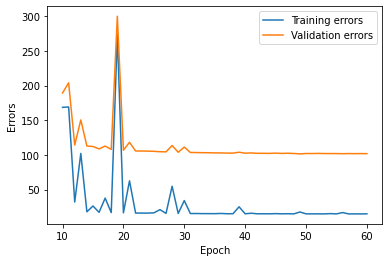

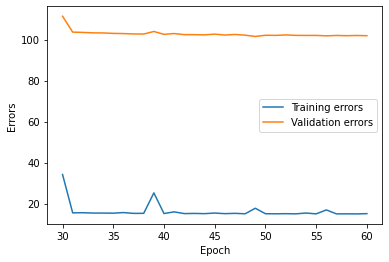

In [8]:
vec_lstm = LSTMVectorized(NODES, 4, 1, 64)

vec_lstm.train_model(training_dataset,
                  validation_dataset,
                  EPOCHS,
                  lr=LEARNING_RATE,
                  lr_decay=LR_DECAY)

torch.save(vec_lstm.state_dict(), 'models/1_nodes/vec_lstm.pt')

vec_lstm.plot_loss(10)
vec_lstm.plot_loss(30)

### Training Several RNNs

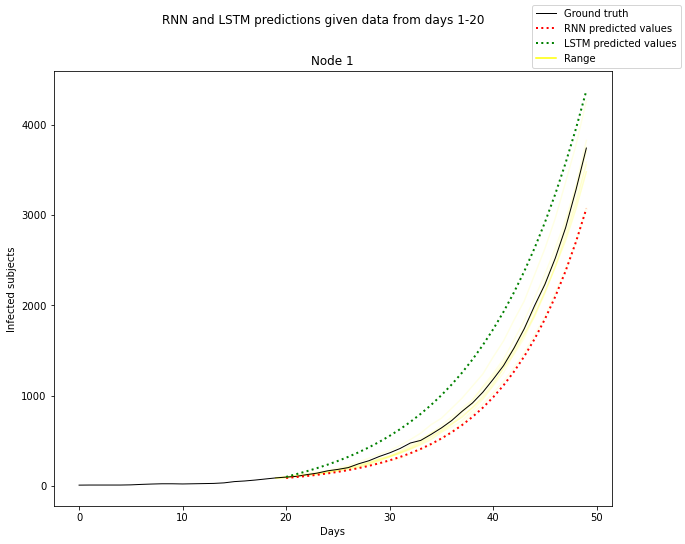

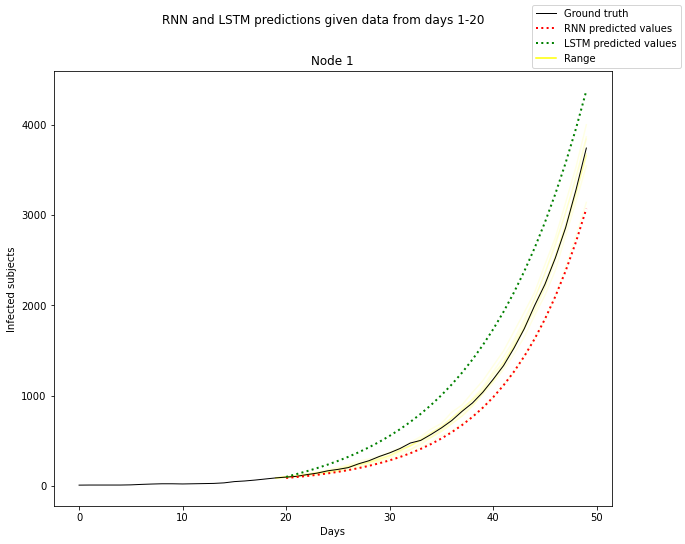

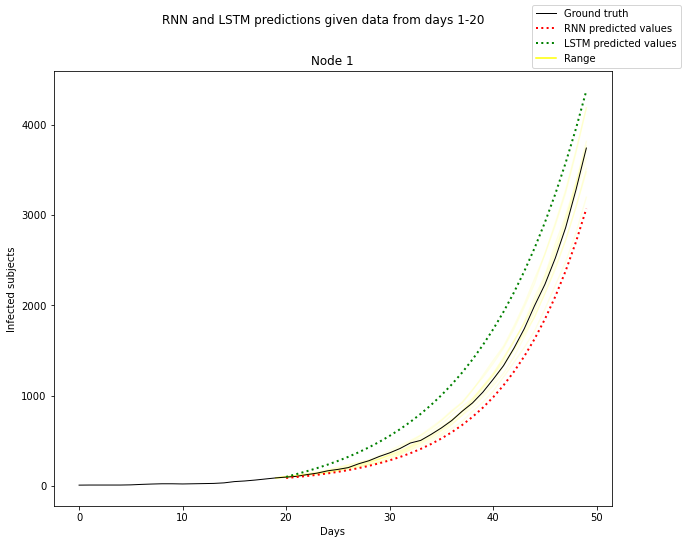

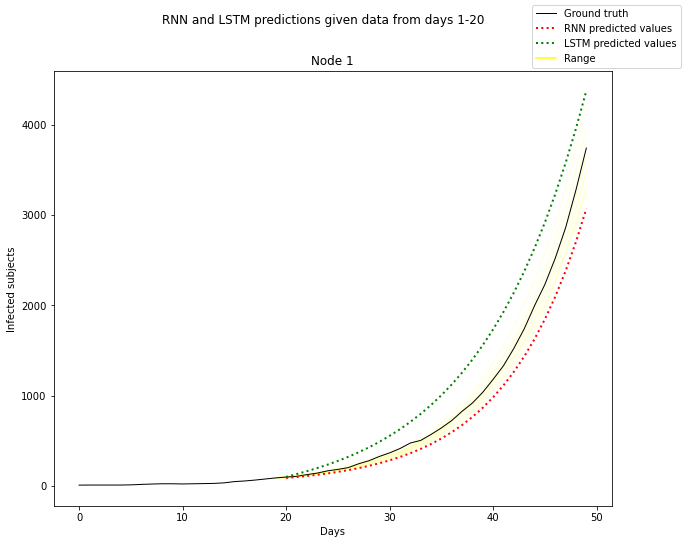

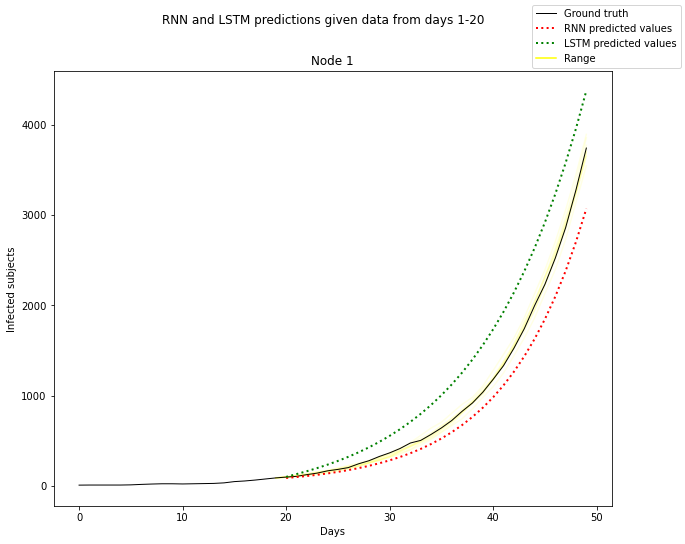

In [16]:
sims = np.load('data/fixed-parameters/150sims_50days_1nodes.npy')

for i in range(5):
    rnn = RNNVectorized(1, 4, 1, 128)
    rnn.load_state_dict(torch.load('models/1_nodes/vec_rnn.pt'))

    lstm = LSTMVectorized(1, 4, 1, 64)
    lstm.load_state_dict(torch.load('models/1_nodes/vec_lstm.pt'))
    graph_compare_rnn_lstm(rnn, lstm, sim, 20, 30, 1, 10)

In [ ]:
hidden_size_list = [32, 64, 128, 256]

for i, hidden_size in enumerate(hidden_size_list):
    save_path = 'models/1_nodes/'
    vec_rnn = RNNVectorized(NODES, 4, 1, hidden_size)

    vec_rnn.train_model(training_dataset,
                      validation_dataset,
                      EPOCHS,
                      lr=LEARNING_RATE,
                      lr_decay=LR_DECAY)

    torch.save(vec_rnn.state_dict(), 'models/1_nodes/vec_rnn.pt')

    vec_rnn.plot_loss(10)
    vec_rnn.plot_loss(30)